 (\#号后面的东西不一定有用但是先不要删.)

# STA141B FINAL GROUP PROJECT

In [2]:
# import urllib.request, urllib.parse, urllib.error
# import lxml
# from collections import Counter
# import xml.etree.ElementTree as ET
# import ssl
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json,sys
import re
from matplotlib import pyplot as plt
import plotnine as p9
from plotnine import *
import sqlalchemy as sqla
import numpy as np

In [2]:
# web API,  parse HTML
url = 'https://datahub.io/core/covid-19#data-cli'
html_text = requests.get(url).text
soup = BeautifulSoup(html_text, 'html.parser')


In [3]:
html = []
df = {}
count = 1
for link in soup.find_all('a'):
    str_link = str(link.get('href'))
    
    if str_link.startswith('/core/covid-19/r/') and re.search('json$',str_link):
        html.append('https://datahub.io' + str_link)
        js = requests.get('https://datahub.io' + str_link).json() 
        df[count] =  pd.DataFrame(js)
        count += 1


In [4]:
html # so we have total 8 dataframe with using under data

['https://datahub.io/core/covid-19/r/countries-aggregated.json',
 'https://datahub.io/core/covid-19/r/key-countries-pivoted.json',
 'https://datahub.io/core/covid-19/r/reference.json',
 'https://datahub.io/core/covid-19/r/time-series-19-covid-combined.json',
 'https://datahub.io/core/covid-19/r/us_confirmed.json',
 'https://datahub.io/core/covid-19/r/us_deaths.json',
 'https://datahub.io/core/covid-19/r/us_simplified.json',
 'https://datahub.io/core/covid-19/r/worldwide-aggregate.json']

In [5]:
df[1] # example: the 1st table

,Confirmed,Country,Date,Deaths,Recovered
0,0,Afghanistan,2020-01-22,0,0
1,0,Afghanistan,2020-01-23,0,0
2,0,Afghanistan,2020-01-24,0,0
3,0,Afghanistan,2020-01-25,0,0
4,0,Afghanistan,2020-01-26,0,0
...,...,...,...,...,...
131707,133593,Zimbabwe,2021-11-19,4699,0
131708,133615,Zimbabwe,2021-11-20,4699,0
131709,133647,Zimbabwe,2021-11-21,4699,0
131710,133674,Zimbabwe,2021-11-22,4699,0


### 先随便搞点分析找灵感
### 先分析worldwide，再US
### Plots
#### Part I. Look at the time trend for confirmed cases in key countries

In [71]:
melt_key_country = pd.melt(df[2], id_vars=['Date'], 
               value_vars=['China','US','United_Kingdom','Italy','France','Germany','Spain','Iran'])
melt_key_country = melt_key_country.rename(columns={'variable':'country','value':'death'})
melt_key_country['death'] = pd.to_numeric(melt_key_country['death'],errors='coerce')
melt_key_country['Date'] = melt_key_country['Date'].astype(str)
melt_key_country['Date'] = pd.to_datetime(melt_key_country['Date'])
melt_key_country

,Date,country,death
0,2020-01-22,China,548
1,2020-01-23,China,643
2,2020-01-24,China,920
3,2020-01-25,China,1406
4,2020-01-26,China,2075
...,...,...,...
5371,2021-11-19,Iran,6069559
5372,2021-11-20,Iran,6073098
5373,2021-11-21,Iran,6077438
5374,2021-11-22,Iran,6082865


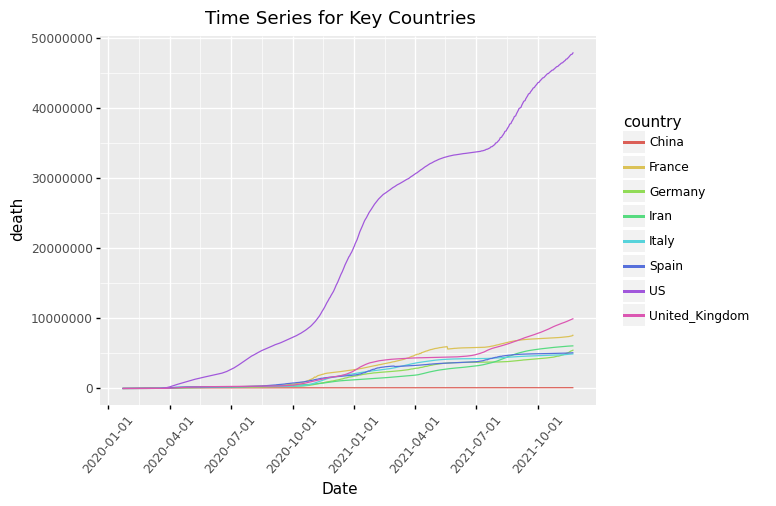

<ggplot: (8774927460268)>

In [72]:
(p9.ggplot(melt_key_country)
#+ p9.facet_wrap('~country',scales = 'free') 
+ p9.aes(x='Date',y='death',colour = 'country') 
+ p9.geom_line() 
+ p9.labs(title = 'Time Series for Key Countries')
+ p9.theme(axis_text_x = p9.element_text(angle=50))
)

#### Part II. Worldwide confirmation increasing rate

In [73]:
worldwide = df[8]
worldwide['Confirmed'] = pd.to_numeric(worldwide['Confirmed'],errors='coerce')
worldwide['Increase rate'] = pd.to_numeric(worldwide['Increase rate'],errors='coerce')
worldwide['Date'] = worldwide['Date'].astype(str)
worldwide['Date'] = pd.to_datetime(worldwide['Date'])

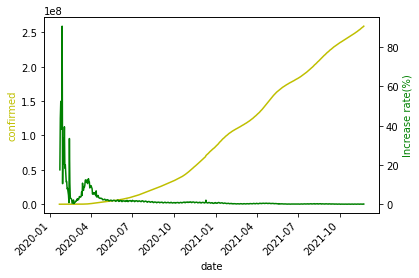

In [74]:
x = worldwide['Date']
y1 = worldwide['Confirmed']
y2 = worldwide['Increase rate']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'y-')
ax2.plot(x, y2, 'g-')

ax1.set_xlabel('date')
ax1.set_ylabel('confirmed', color='y')
ax2.set_ylabel('Increase rate(%)', color='g')
fig.autofmt_xdate(rotation=45)
plt.show()

#### SQL

In [76]:
us_simplified = df[7]
sqlite_file = 'covid19.sqlite'
covid19 = sqla.create_engine('sqlite:///' + sqlite_file)
us_simplified.to_sql('US',covid19,if_exists='append')

## US 分界线

#### combine dataframe us_confirmed, us_deaths as us_simplified

In [33]:
us_confirmed = df[5].drop('Country/Region', 1).rename(columns={"Case": "Confirmed"})
us_deaths = df[6].drop('Country/Region', 1).rename(columns={"Case": "Deaths"})


<ipython-input-33-22ff785bbc36>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  us_confirmed = df[5].drop('Country/Region', 1).rename(columns={"Case": "Confirmed"})
<ipython-input-33-22ff785bbc36>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  us_deaths = df[6].drop('Country/Region', 1).rename(columns={"Case": "Deaths"})


In [34]:
us_simplified = us_confirmed.merge(us_deaths,how='left', left_on=['Date','Province/State','Admin2'], 
                   right_on = ['Date','Province/State','Admin2'])


Index(['Admin2', 'Confirmed', 'Date', 'Province/State', 'Deaths'], dtype='object')

In [67]:
us_simplified.describe()

,Confirmed,Deaths
count,2.245824e+06,2.245824e+06
mean,5.818311e+03,1.072603e+02
std,2.728276e+04,5.300722e+02
min,0.000000e+00,0.000000e+00
25%,4.800000e+01,0.000000e+00
50%,7.800000e+02,1.300000e+01
75%,3.241000e+03,6.000000e+01
max,1.521197e+06,2.704600e+04


In [68]:
# IF we only look at the 25% highest 
high = us_simplified[us_simplified['Confirmed'] >= 3.241000e+03]
high

,Admin2,Confirmed,Date,Province/State,Deaths
325,Autauga,3258,2020-12-12,Alabama,41
326,Autauga,3300,2020-12-13,Alabama,41
327,Autauga,3329,2020-12-14,Alabama,41
328,Autauga,3426,2020-12-15,Alabama,43
329,Autauga,3510,2020-12-16,Alabama,43
...,...,...,...,...,...
2243803,Uinta,4005,2021-11-19,Wyoming,30
2243804,Uinta,4005,2021-11-20,Wyoming,30
2243805,Uinta,4005,2021-11-21,Wyoming,30
2243806,Uinta,4006,2021-11-22,Wyoming,30


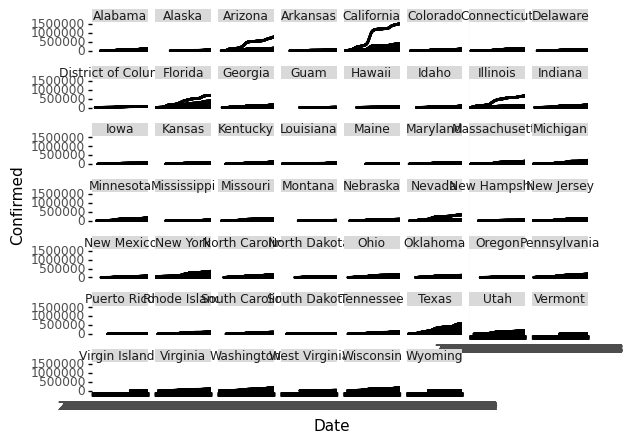

<ggplot: (8774963382285)>

In [70]:
gg = ggplot(high)
gg += p9.facet_wrap('Province/State')  
gg += p9.aes(x='Date', y='Confirmed')
gg += geom_point(size = 0.1)
gg

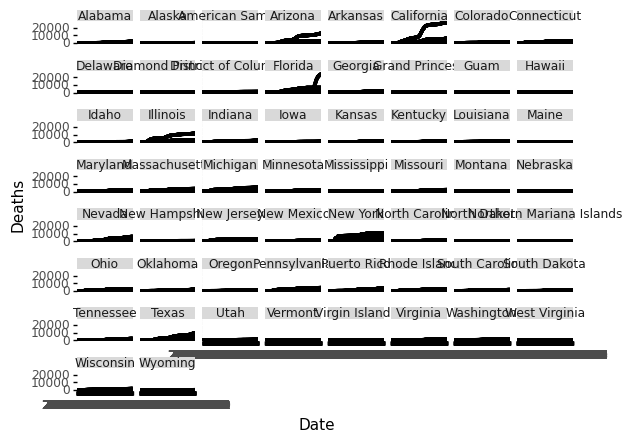

<ggplot: (8775015977957)>

In [43]:
# plt.scatter(us_simplified['Date'],us_simplified['Deaths'])
gg = ggplot(us_simplified)
gg += p9.facet_wrap('Province/State')  
gg += p9.aes(x='Date', y='Deaths')
gg += geom_point(size = 0.5)
gg

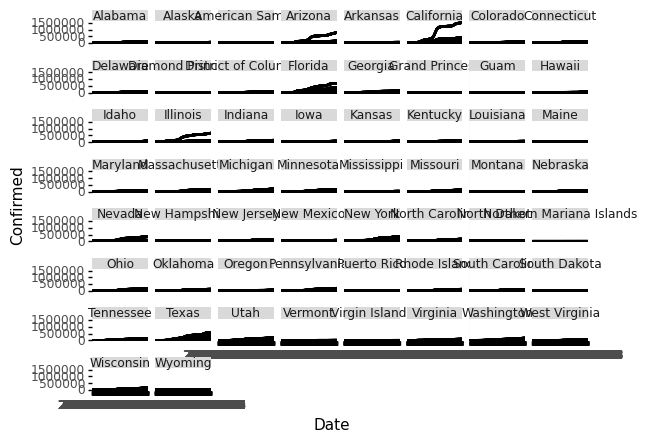

<ggplot: (8774996791281)>

In [45]:
gg = ggplot(us_simplified)
gg += p9.facet_wrap('Province/State')  # plot group by national values
gg += p9.aes(x='Date', y='Confirmed')
gg += geom_point(size = 0.1)
gg


AttributeError: 'AxesSubplot' object has no attribute 'groupby'

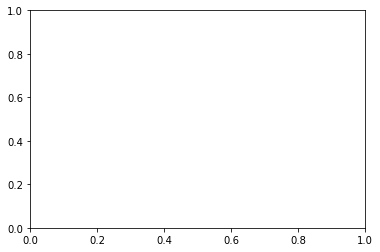

In [54]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# lns1 = ax.groupby('Province/State').plot(us_simplified['Date'], us_simplified['Confirmed'])
# # ,color = 'red',label = 'smoothed_cli
# ax.figure.autofmt_xdate()
# axx = ax.twinx()

# lns2 = axx.groupby('Province/State').plot(us_simplified['Date'], us_simplified['Deaths'])

# lns = lns1+lns2
# lbs = [l.get_label() for l in lns]
# ax.legend(lns,lbs,loc=0)

# fig.tight_layout()
# plt.show()